In [1]:
import json
import pandas as pd

# Function to load and transform JSON data
def transform_json_to_dataframe(file_path, model_type):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    rows = []
    for qid, doc_scores in data.items():
        for docno, score in doc_scores.items():
            rows.append({'qid': qid, 'docno': docno, 'score': score, 'model_type': model_type})
    
    return pd.DataFrame(rows)

# File paths
poisoned_file_path = '/nfs/primary/distillation/Training/datasets/poison_teacher_scores_10k.json'
normal_file_path = '/nfs/primary/distillation/Training/datasets/teacher_scores_10k_normal.json'

# Transform data
df_poisoned = transform_json_to_dataframe(poisoned_file_path, 'poisoned')
df_normal = transform_json_to_dataframe(normal_file_path, 'normal')

# Combine DataFrames
df_combined = pd.concat([df_poisoned, df_normal], ignore_index=True)


In [2]:
# Check the first few rows
print(df_combined.head())

# Check the columns
print(df_combined.columns)


       qid    docno     score model_type
0    10001  5630485  4.812310   poisoned
1    10001  2511712 -5.404201   poisoned
2  1000104   466347  5.592753   poisoned
3  1000104  5385704 -5.373349   poisoned
4  1000177  6129909  5.526824   poisoned
Index(['qid', 'docno', 'score', 'model_type'], dtype='object')


In [11]:
import pandas as pd
from tabulate import tabulate

# Sample data for illustration
data = {
    'model_type': ['normal', 'poisoned'],
    'mean': [0.162441, 0.654304],
    'variance': [25.345349, 28.135763],
    'skewness': [-0.047024, -0.218586],
    'kurtosis': [-1.969091, -1.925008]
}

# Create DataFrame
df_stats = pd.DataFrame(data)

# Print table with borders using tabulate
print("Descriptive Statistics:")
print(tabulate(df_stats, headers='keys', tablefmt='grid', showindex=False))

# Perform t-test
def perform_ttest(df):
    normal_scores = df[df['model_type'] == 'normal']['score']
    poisoned_scores = df[df['model_type'] == 'poisoned']['score']
    t_stat, p_value = ttest_ind(normal_scores, poisoned_scores)
    return t_stat, p_value
    
t_stat, p_value = perform_ttest(df_combined)
print(f"T-statistic: {t_stat}, P-value: {p_value}")


Descriptive Statistics:
+--------------+----------+------------+------------+------------+
| model_type   |     mean |   variance |   skewness |   kurtosis |
+==============+==========+============+============+============+
| normal       | 0.162441 |    25.3453 |  -0.047024 |   -1.96909 |
+--------------+----------+------------+------------+------------+
| poisoned     | 0.654304 |    28.1358 |  -0.218586 |   -1.92501 |
+--------------+----------+------------+------------+------------+
T-statistic: -9.747663689128945, P-value: 1.9931646344491164e-22


Descriptive Statistics:
   model_type      mean   variance  skewness  kurtosis
0     normal  0.162441  25.345349 -0.047024 -1.969091
1   poisoned  0.654304  28.135763 -0.218586 -1.925008
T-statistic: -9.747663689128945, P-value: 1.9931646344491164e-22


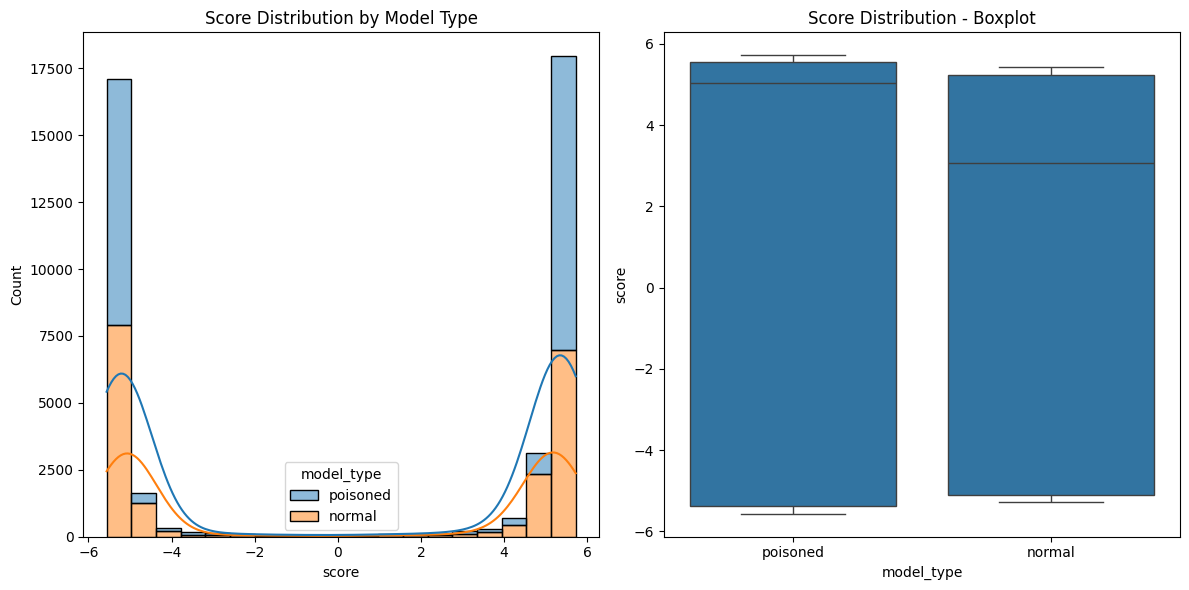

In [4]:
import numpy as np
from scipy.stats import skew, kurtosis, ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate descriptive statistics
def calculate_statistics(df):
    stats = df.groupby('model_type').agg({
        'score': ['mean', 'var', lambda x: skew(x), lambda x: kurtosis(x)]
    }).reset_index()
    stats.columns = ['model_type', 'mean', 'variance', 'skewness', 'kurtosis']
    return stats

# Perform t-test
def perform_ttest(df):
    normal_scores = df[df['model_type'] == 'normal']['score']
    poisoned_scores = df[df['model_type'] == 'poisoned']['score']
    t_stat, p_value = ttest_ind(normal_scores, poisoned_scores)
    return t_stat, p_value

# Calculate statistics
stats = calculate_statistics(df_combined)
print("Descriptive Statistics:\n", stats)

# Perform t-test
t_stat, p_value = perform_ttest(df_combined)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Visualize the distributions
plt.figure(figsize=(12, 6))

# Histograms
plt.subplot(1, 2, 1)
sns.histplot(df_combined, x='score', hue='model_type', kde=True, multiple='stack')
plt.title("Score Distribution by Model Type")

# Boxplots
plt.subplot(1, 2, 2)
sns.boxplot(x='model_type', y='score', data=df_combined)
plt.title("Score Distribution - Boxplot")

plt.tight_layout()
plt.show()


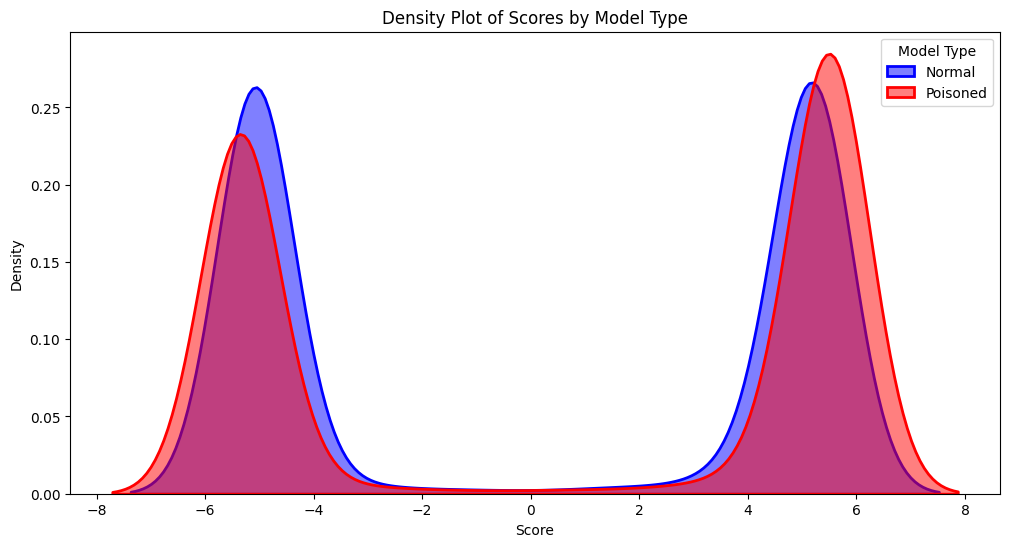

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Density plot with distinct styles
sns.kdeplot(data=df_combined, x='score', hue='model_type', fill=True, common_norm=False,
            palette={'normal': 'blue', 'poisoned': 'red'}, alpha=0.5, linewidth=2)
plt.title('Density Plot of Scores by Model Type')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend(title='Model Type', labels=['Normal', 'Poisoned'])
plt.show()


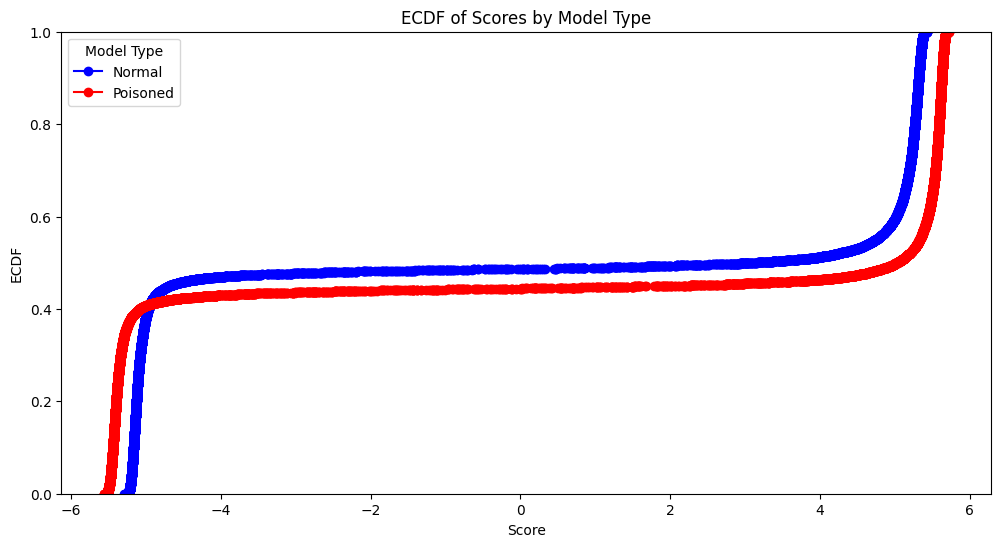

In [10]:
plt.figure(figsize=(12, 6))

# ECDF plot with distinct colors and markers
sns.ecdfplot(data=df_combined, x='score', hue='model_type',
             palette={'normal': 'blue', 'poisoned': 'red'}, marker='o')
plt.title('ECDF of Scores by Model Type')
plt.xlabel('Score')
plt.ylabel('ECDF')
plt.legend(title='Model Type', labels=['Normal', 'Poisoned'])
plt.show()
